In [1]:
import torch

class LinearNet(torch.nn.Module):

    def __init__(self, d_in):
        super(LinearNet, self).__init__()
        self.linear = torch.nn.Linear(d_in, 1, bias=True)
        self.linear.weight.data.fill_(0.0)

    def forward(self, x):
        return self.linear(x)

In [2]:
from tqdm import tqdm
from torch.nn.functional import sigmoid

OVERALL_SCALE = 1.0

def get_random_feat(d, salience=1.0, orthogonal_to=None):
    feat = torch.randn(d)
    if orthogonal_to is not None:
        assert orthogonal_to.ndim == 2
        assert orthogonal_to.shape[1] == feat.shape[0], (orthogonal_to.shape, feat.shape)
        proj = feat @ orthogonal_to.T
        feat = feat - proj @ orthogonal_to
    return feat / feat.norm() * salience * OVERALL_SCALE

def generate_data(
    n=1000,
    n_trusted=100,
    d_in=100,
    gt_salience = 1.0,
    proxy_saliences = (1.0,),
    proxy_accuracies = (0.75,),
    noise = 0.0,
):
    """    
    Returns:
    X: torch.Tensor of shape (n, d_in) that is a sum of a ground truth feature, 
        proxy features whose errors are independent of each other, and noise
    y: torch.Tensor of shape (n, len(proxy_accuracies)) that has a proxy label for each proxy
    """
    assert len(proxy_saliences) == len(proxy_accuracies) > 0
    
    gt = torch.randint(0, 2, (n, 1)).float()
    gt_feat = get_random_feat(d_in, gt_salience)
    gt_feats = gt_feat.expand(n, -1) * (gt * 2 - 1)
    
    proxies = [
        (gt.squeeze(-1) == (torch.rand(n) < acc)).float()  # TODO: maybe turn into soft labels
        for acc in proxy_accuracies
    ]
    per_proxy_feat = [get_random_feat(d_in, salience) for salience in proxy_saliences]
    proxy_feats = [
        feat.expand(n, -1) * (proxy * 2 - 1)[:, None]
        for feat, proxy in zip(per_proxy_feat, proxies)
    ]
    X = (sum(proxy_feats) + gt_feats) + torch.randn(n, d_in) * noise * OVERALL_SCALE
    proxies = torch.stack(proxies).T

    # define trusted set
    # note that this may be unrealistic because there's little structure to
    # the distribution shift from trusted to untrusted
    y_trusted = torch.randint(0, 2, (n_trusted, 1)).float()
    trusted_feat = gt_feat + sum(per_proxy_feat)
    X_trusted = trusted_feat.expand(n_trusted, -1) * (y_trusted * 2 - 1)

    return X, proxies, gt, X_trusted, y_trusted, gt_feat, per_proxy_feat


def train_model(
    X_train, X_test, y_train, y_test,
    X_trusted=None, y_trusted=None,
    n_epochs=1,
    lr=1.0,
    batch_size=64,
    device='cuda',
):
    model = LinearNet(X_train.shape[1]).to(device)
    assert X_train.shape[0] % batch_size == 0
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    n_train = X_train.shape[0]
    n_steps = n_train * n_epochs // batch_size
    n_test = X_test.shape[0]
    model_n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # loss_fn = torch.nn.BCEWithLogitsLoss()
    # It seems that one of the conditions for this to provably work is that the gradients
    # only depend on the sign of the model's error. So we use absolute error loss here.
    loss_fn = lambda y_pred, y: (sigmoid(y_pred) - y).abs().mean()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    all_test_preds = torch.full((n_steps * batch_size, n_test), torch.nan, device=device)
    all_jvps = torch.full((n_steps * batch_size, n_test), torch.nan, device=device)
    all_steps = torch.full((n_steps * batch_size,), torch.nan, device=device)
    if X_trusted is not None and y_trusted is not None:
        X_trusted = X_trusted.to(device)
        y_trusted = y_trusted.to(device)
        n_trusted = X_trusted.shape[0]
        synthetic_preds = {k: torch.full((n_steps * n_trusted, n_test), torch.nan, device=device) for k in ["trusted", "synthetic"]}
        synthetic_jvps = {k: torch.full((n_steps * n_trusted, n_test), torch.nan, device=device) for k in ["trusted", "synthetic"]}
        synthetic_steps = {k: torch.full((n_steps * n_trusted,), torch.nan, device=device) for k in ["trusted", "synthetic"]}
    else:
        synthetic_preds = synthetic_jvps = synthetic_steps = None
        
    step = 0
    for epoch in range(n_epochs):
        for i in tqdm(range(0, X_train.shape[0], batch_size), desc=f'Epoch {epoch + 1}/{n_epochs}', total=n_train // batch_size):
            test_jacobians, test_preds = get_jacobians(model, X_test)

            if X_trusted is not None and y_trusted is not None:
                for k in ["trusted", "synthetic"]:
                    optimizer.zero_grad()
                    y_batch = y_trusted if k == "trusted" else 1 - y_trusted
                    cumul_grads = torch.full((n_trusted, model_n_params), torch.nan, device=device)
                    for j in range(n_trusted):
                        y_pred = model(X_trusted[j:j+1])
                        loss = loss_fn(y_pred, y_batch[j:j+1, 0].unsqueeze(-1)) / batch_size
                        loss.backward()

                        cumul_grads[j] = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
                    
                    grads = cumul_grads.diff(dim=0, prepend=torch.zeros(1, model_n_params, device=device))
                    current_lr = optimizer.param_groups[0]['lr']
                    update = -current_lr * grads
                    jvp = update @ test_jacobians.T

                    start, stop = step * n_trusted, (step + 1) * n_trusted
                    synthetic_preds[k][start:stop, :] = test_preds  # type: ignore
                    synthetic_jvps[k][start:stop, :] = jvp  # type: ignore
                    synthetic_steps[k][start:stop] = step  # type: ignore
                    
            optimizer.zero_grad()
            cumul_grads = torch.full((batch_size, model_n_params), torch.nan, device=device)
            for j in range(i, min(i + batch_size, n_train)):
                X_batch = X_train[j:j+1]
                y_batch = y_train[j:j+1] 
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch[:, 0].unsqueeze(-1)) / batch_size  # train on proxy 0
                loss.backward()

                cumul_grads[j - i] = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
            
            grads = cumul_grads.diff(dim=0, prepend=torch.zeros(1, model_n_params, device=device))
            current_lr = optimizer.param_groups[0]['lr']
            update = -current_lr * grads
            jvp = update @ test_jacobians.T

            all_test_preds[i:i+batch_size, :] = test_preds
            all_jvps[i:i+batch_size, :] = jvp
            all_steps[i:i+batch_size] = step
            
            optimizer.step()
            step += 1

    
    return model, all_test_preds, all_jvps, all_steps, synthetic_preds, synthetic_jvps, synthetic_steps

def get_jacobians(model, X_test):
    """
    Returns the Jacobian of the model's (logodds) output with respect to its parameters
    """
    
    model_n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    jacobians = torch.full((X_test.shape[0], model_n_params), torch.nan, device=X_test.device)
    preds = torch.full((X_test.shape[0],), torch.nan, device=X_test.device)
    for i, x in enumerate(X_test):
        y = model(x.unsqueeze(0))
        y.backward()
        jacobian = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
        jacobians[i] = jacobian
        preds[i] = y
        model.zero_grad()
    return jacobians, preds


In [3]:
from concept_erasure import LeaceEraser
from typing import Literal
import numpy as np

def erase_labels(x, soft_labels, label_erasure: Literal["none", "leace", "mean-diff", "keep-negative", "keep-positive"] = "none"):
    mask = np.full_like(soft_labels, True, dtype=bool)
    if label_erasure == "leace":
        eraser = LeaceEraser.fit(x=torch.from_numpy(x), z=torch.from_numpy(soft_labels))
        erased = eraser(x=torch.tensor(x)).numpy()
    elif label_erasure == "mean-diff":
        pos_mean = np.mean(x * soft_labels[:, None], axis=0)
        neg_mean = np.mean(x * (1 - soft_labels)[:, None], axis=0)
        mean_diff = pos_mean - neg_mean
        mean_diff = mean_diff / np.linalg.norm(mean_diff)
        erased = x - x @ mean_diff[:, None] * mean_diff[None, :] / (mean_diff @ mean_diff)
    elif label_erasure == "keep-negative":
        mask = soft_labels < 0.5
        erased = x[mask]
    elif label_erasure == "keep-positive":
        mask = soft_labels > 0.5
        erased = x[mask]
    elif label_erasure == "none":
        erased = x
    else:
        raise ValueError(f"Unknown label erasure method {label_erasure}")
    return erased, mask

In [31]:
from sklearn.metrics import roc_auc_score, accuracy_score

proxy_settings = [
    # ((1.0,), (0.75,)),
    # ((1.0, 1.0), (0.75, 0.75)),
    # ((1.0, 1.0), (0.75, 0.55)),
    # ((1.0, 1.0), (0.55, 0.55)),
    # ((1.0, 1.0), (0.55, 0.75)),
    # ((1.0, 1.0), (0.75, 0.9)),
    # ((1.0, 1.0), (0.9, 0.9)),
    # ((1.0, 1.0), (0.99, 0.9)),
    # ((1.0, 0.5), (0.75, 0.9)),
    # ((1.0, 2.0), (0.55, 0.75)),
    # ((1.0, 2.0), (0.55, 0.25)),
    # ((1.0, 2.0), (0.99, 0.25)),
    # ((1.0, 2.0), (0.99, 0.75)),
    # ((1.0, 2.0), (0.75, 0.5)),
    # ((1.0, 2.0), (0.75, 0.75)),
    # ((1.0, 2.0, 1.0), (0.75, 0.25, 0.5)),
    # ((1.0, 2.0, 1.0), (0.75, 0.5, 0.9)),
    # ((1.0, 1.0, 1.0), (0.75, 0.65, 0.5)),
    # ((1.0, 1.0, 1.0), (0.75, 0.5, 0.5)),
    ((1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.5), (0.75, 0.25, 0.5, 0.9, 0.75, 0.25, 0.5)),
]
num_seeds = 10
results = []
for proxy_saliences, proxy_accuracies in tqdm(proxy_settings, desc='Proxy settings', total=len(proxy_settings)):
    print(f"Proxy saliences: {proxy_saliences}, proxy accuracies: {proxy_accuracies}")
    for seed in range(num_seeds):
        print(f"Seed {seed}")
        torch.manual_seed(seed)

        X, y, gt, X_trusted, y_trusted, gt_feat, per_proxy_feat = generate_data(
            n=512 + 512,
            d_in=2048,
            gt_salience=1.0,
            proxy_saliences=proxy_saliences,
            proxy_accuracies=proxy_accuracies,
            noise=0.0,
        )
        n_train = 512
        batch_size = 512
        X_train, X_test = X[:n_train], X[n_train:]
        y_train, y_test = y[:n_train], y[n_train:]
        gt_train, gt_test = gt[:n_train], gt[n_train:]

        model, all_test_preds, all_jvps, all_steps, synthetic_preds, synthetic_jvps, synthetic_steps = train_model(X_train, X_test, y_train, y_test, X_trusted=X_trusted, y_trusted=y_trusted, n_epochs=1, lr=1., batch_size=batch_size)
        all_test_preds, all_jvps, all_steps = all_test_preds.detach().cpu().numpy(), all_jvps.detach().cpu().numpy(), all_steps.detach().cpu().numpy()

        ceil_model, ceil_all_test_preds, ceil_all_jvps, ceil_all_steps, _, _, _ = train_model(X_train, X_test, gt_train, gt_test, n_epochs=1, lr=1., batch_size=batch_size)
        ceil_all_test_preds, ceil_all_jvps, ceil_all_steps = ceil_all_test_preds.detach().cpu().numpy(), ceil_all_jvps.detach().cpu().numpy(), ceil_all_steps.detach().cpu().numpy()

        X_train, X_test, y_train, y_test, gt_train, gt_test = X_train.cpu().numpy(), X_test.cpu().numpy(), y_train.cpu().numpy(), y_test.cpu().numpy(), gt_train.cpu().numpy(), gt_test.cpu().numpy()
        X_trusted, y_trusted = X_trusted.cpu().numpy(), y_trusted.cpu().numpy()
        assert synthetic_preds is not None and synthetic_jvps is not None and synthetic_steps is not None
        for k in ["trusted", "synthetic"]:
            synthetic_preds[k] = synthetic_preds[k].detach().cpu().numpy()
            synthetic_jvps[k] = synthetic_jvps[k].detach().cpu().numpy()
            synthetic_steps[k] = synthetic_steps[k].detach().cpu().numpy()

        # summary stats
        aucs = [roc_auc_score(y_test[:, 0], test_preds) for test_preds in all_test_preds]

        metric = "acc"
        metric_fn = {
            "auc": lambda y_true, y_pred: roc_auc_score(y_true, y_pred),
            "acc": lambda y_true, y_pred: accuracy_score(y_true, y_pred > 0),
        }[metric]
        weak_floor = metric_fn(gt_test[:, 0], y_test[:, 0])
        strong_ceil = metric_fn(gt_test[:, 0], ceil_all_test_preds[-1])
        w2s_auroc = metric_fn(gt_test[:, 0], all_test_preds[-1])
        w2s_auroc_against_weak = metric_fn(y_test[:, 0], all_test_preds[-1])
        pgr = (w2s_auroc - weak_floor) / (strong_ceil - weak_floor)
        print(f"Weak floor {metric}: {weak_floor:.3f}")
        print(f"Strong ceiling {metric}: {strong_ceil:.3f}")
        print(f"W2S {metric} (against weak): {w2s_auroc_against_weak:.3f}")
        print(f"W2S {metric}: {w2s_auroc:.3f} (PGR={pgr:.3f})")

        erasure = "none"
        weak_label_erased, _ = erase_labels(all_jvps, y_train[:, 0], label_erasure=erasure)

        synth_erased = {k: erase_labels(synthetic_jvps[k], y_trusted[:, 0].repeat(n_train // batch_size, axis=0), label_erasure=erasure)[0] for k in ["trusted", "synthetic"]}  # type: ignore
        diff = synth_erased["trusted"].mean(0) - synth_erased["synthetic"].mean(0)
        diff /= np.linalg.norm(diff)
        proj_diff = weak_label_erased @ diff

        # we claim to be able to distinguish cases where all of our measurements are correct
        # from cases where our first proxy is incorrect 
        # (we don't care about cases where other proxies are incorrect but the first one is correct since we can discard them anyways)
        all_agree_or_gt_disagrees = (y_train.std(axis=-1) == 0) | (gt_train[:, 0] != y_train[:, 0])
        print(f"Keeping {100 * all_agree_or_gt_disagrees.mean():.1f}% of examples for measuring tampering AUC")
        is_y0_correct = (gt_train[:, 0] == y_train[:, 0])[all_agree_or_gt_disagrees]
        try:
            meas_tamp_auc = roc_auc_score(is_y0_correct, proj_diff[all_agree_or_gt_disagrees])
        except ValueError as e:
            print(e)
            meas_tamp_auc = np.nan
            print("All examples were", is_y0_correct.mean())
        print(f"Meas. tampering AUC: {meas_tamp_auc:.3f}")
        results.append({
            "proxy_saliences": proxy_saliences,
            "proxy_accuracies": proxy_accuracies,
            "seed": seed,
            "weak_floor": weak_floor,
            "strong_ceil": strong_ceil,
            "w2s_auroc": w2s_auroc,
            "w2s_auroc_against_weak": w2s_auroc_against_weak,
            "pgr": pgr,
            "meas_tamp_auc": meas_tamp_auc,
        })
        if meas_tamp_auc < 0.9999999:
            print("Meas. tampering AUC < 1")
            print(results[-1])
        print()
        break

Proxy settings:   0%|          | 0/1 [00:00<?, ?it/s]

Proxy saliences: (1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.5), proxy accuracies: (0.75, 0.25, 0.5, 0.9, 0.75, 0.25, 0.5)
Seed 0


Proxy settings: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Weak floor acc: 0.748
Strong ceiling acc: 0.480
W2S acc (against weak): 0.533
W2S acc: 0.520 (PGR=0.854)
Keeping 22.7% of examples for measuring tampering AUC
Meas. tampering AUC: 1.000



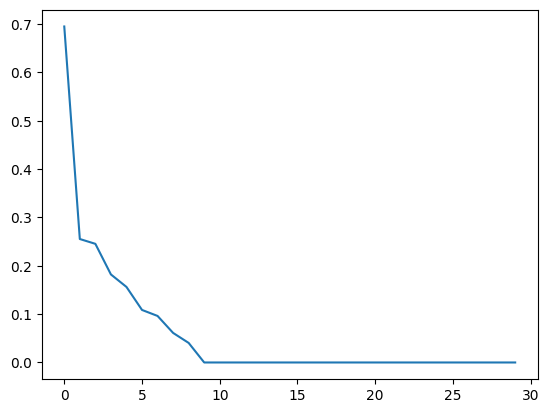

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=30)
reduced = svd.fit_transform(weak_label_erased)
synth_reduced = {k: svd.transform(synth_erased[k]) for k in ["trusted", "synthetic"]}

plt.plot(svd.singular_values_)

In [33]:
np.std([2] * 10 + [-2] * 30)

1.7320508075688772

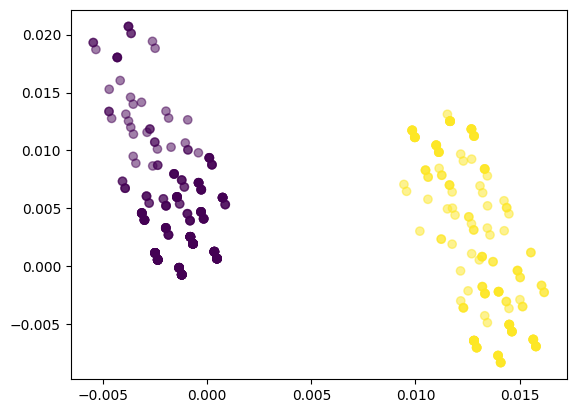

In [48]:
plt.scatter(reduced[:, 3], reduced[:, 4], c=y_train[:, 1] == y_train[:, 0], alpha=0.5)

In [49]:
gt_acc_lower_est = 0.7
for i, basis in enumerate(svd.components_):
    std = reduced[:, i].std()  # this is \delta_i (assuming gt labels are balanced and updates are always \pm\delta_i because the \delta_i's are orthogonal)
    mean = reduced[:, i].mean()
    thresh = gt_acc_lower_est * std + (1 - gt_acc_lower_est) * -std
    can_be_gt = np.abs(mean) > thresh and svd.explained_variance_ratio_[i] > 0.0001  # thought it could still have a positivei inner product with the gt direction
    print(f"Component {i} can{'' if can_be_gt else ' NOT'} be the gt direction with mean {mean:.3f} and std {std:.3f}")
    

Component 0 can be the gt direction with mean 0.021 and std 0.022
Component 1 can NOT be the gt direction with mean 0.001 and std 0.011
Component 2 can NOT be the gt direction with mean 0.001 and std 0.011
Component 3 can be the gt direction with mean 0.004 and std 0.007
Component 4 can be the gt direction with mean 0.004 and std 0.006
Component 5 can NOT be the gt direction with mean 0.000 and std 0.005
Component 6 can NOT be the gt direction with mean 0.000 and std 0.004
Component 7 can NOT be the gt direction with mean 0.000 and std 0.003
Component 8 can NOT be the gt direction with mean 0.000 and std 0.002
Component 9 can NOT be the gt direction with mean 0.000 and std 0.000
Component 10 can NOT be the gt direction with mean 0.000 and std 0.000
Component 11 can NOT be the gt direction with mean -0.000 and std 0.000
Component 12 can NOT be the gt direction with mean -0.000 and std 0.000
Component 13 can NOT be the gt direction with mean -0.000 and std 0.000
Component 14 can NOT be t

In [ ]:
# alternative approach:
# quasi-whiten the data by dividing each svd component by its standard deviation
# then take the overall mean of this quasi-whitened data
# 

In [ ]:
import matplotlib.pyplot as plt

gt_dir = gt_test[:, 0] - 0.5
weak_dir = y_test[:, 0] - 0.5
err_dir = weak_dir - gt_dir
min_step, max_step = 0, 2  # all_steps.max()
step_mask = (all_steps >= min_step) & (all_steps < max_step)
proj_weak = (weak_label_erased @ weak_dir)[step_mask]
# proj_weak = (weak_label_erased @ err_dir)[step_mask]
# proj_weak = (weak_label_erased @ diff)[step_mask]
proj_gt = (weak_label_erased @ gt_dir)[step_mask]
plt.scatter(proj_weak, proj_gt, c=(y_train[:, 0] - gt_train[:, 0])[step_mask], cmap="viridis", alpha=0.5)
xmin, xmax = proj_weak.min(), proj_weak.max()
plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--")
plt.plot([xmin, xmax], [-xmin, -xmax], color="black", linestyle="--", label="y=$\pm$x")
plt.xlabel("Projection onto weak generalization")
plt.ylabel("Projection onto ground truth generalization")
plt.legend()
plt.colorbar()
